In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab Notebooks/baby_sound/vggish

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/baby_sound/vggish


In [ ]:
from pathlib import Path
print(Path.cwd())
!ls
# %cd /content/drive/Colab Notebooks/lung-sound-vggish-master

/content/drive/MyDrive/Colab Notebooks/baby_sound/vggish
all_examples_movetestset.txt  mel_features.py  vggish_audioset_weights.h5
all_examples.txt	      __pycache__      vggish_input.py
all_examples_vggish.txt       saved_models     vggish_model.h5
all_labels_movetestset.txt    testdata	       vggish_model.h5（副本）
all_labels.txt		      test_test.wav    vggish_params.py


#将文件搬至指定文件夹

In [ ]:
import shutil
import tensorflow as tf
import os
import random
import numpy as np

# print(temp_data)
# print(temp_data[0])
Base_Filepath="./../work/"
# def remove_file(old_path, new_path):
#     print(old_path)
#     print(new_path)
#     filelist = os.listdir(old_path) #列出该目录下的所有文件,listdir返回的文件列表是不包含路径的。
#     print(filelist)
#     for file in filelist:
#         src = os.path.join(old_path, file)
#         dst = os.path.join(new_path, file)
#         # print('src:', src)
#         # print('dst:', dst)
#         shutil.move(src, dst)

class_name_arr = tf.io.gfile.listdir(Base_Filepath+'train')
# remove_file(r"/data/temp1", r"/data/temp2")

for index,sigle_filename in enumerate(class_name_arr):
  print(str(index) +"handling...")
  if not os.path.exists("./"+sigle_filename): os.mkdir("./"+sigle_filename)  # 如果不存在这个excelReport文件夹，就自动创建一个
  #获取文件目录下的文件列表 并转换文件形式
  doc_name_arr = tf.io.gfile.listdir(Base_Filepath+'train/'+sigle_filename)
  temp_data = np.random.randint(0,len(doc_name_arr)-1,10)
  for indexnum in temp_data:
    doc_name_item = doc_name_arr[indexnum]
    temp_filepath = Base_Filepath+'train/'+sigle_filename+'/'+doc_name_item
    # remove_file(temp_filepath, r"./"+sigle_filename+"/"+doc_name_item)
    shutil.move(temp_filepath, "./"+sigle_filename)
    

[243 326 317  83 149 370 294 259  92 243]
243
0handling...
1handling...
2handling...
3handling...
4handling...
5handling...


In [ ]:
#模型加载
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Layer
model = tf.keras.models.load_model('saved_models/vggish-bigru-model_trainable.h5')

In [ ]:
import vggish_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import vggish_params
import glob
import numpy as np
Time_Len = 10   #设定时长

# Feature Extraction

In [ ]:
Base_Filepath="./../work/"

In [ ]:
import pickle
def save_variable(v,filename):
  f=open(filename,'wb')
  pickle.dump(v,f)
  f.close()
  return filename
def load_variavle(filename):
  f=open(filename,'rb')
  r=pickle.load(f)
  f.close()
  return r
# filename = save_variable(audiodf,'audiodf.txt')
# audiodf = load_variavle('audiodf.txt')

#获取样本和标签的函数

In [ ]:
#获取lable 和 样本  fun
def get_labelAndExamples(class_name_arr):
  for index,sigle_filename in enumerate(class_name_arr):
    print(str(index) +"handling...")
    #获取文件目录下的文件列表 并转换文件形式
    doc_name_arr = tf.io.gfile.listdir(Base_Filepath+'train/'+sigle_filename)
    #处理标签
    target_label = [0]*len(class_name_arr);
    target_label[index]=1
    if index==0:
      all_labels=np.array([target_label]*len(doc_name_arr))
    else:
      all_labels = np.concatenate((all_labels, np.array([target_label]*len(doc_name_arr) ) ))
    #处理每个单独的音频元素
    for doc_name_item in doc_name_arr:
      temp_filepath = Base_Filepath+'train/'+sigle_filename+'/'+doc_name_item
      temp_file_info = vggish_input.wavfile_to_examples(temp_filepath)
      # print(temp_file_info.shape)
      # print(doc_name_item)
      pad_width = Time_Len-len(temp_file_info)
      temp_file_info = np.pad(temp_file_info,((0,pad_width),(0,0),(0,0)),mode='constant')
      # print(temp_file_info.shape)
      # print(temp_file_info.ndim)
      # print("-----------------------------------------------------")
      all_examples.append(np.reshape(temp_file_info, (10, 96, 64, 1)))
  save_variable(all_labels,'all_labels_movetestset.txt')
  save_variable(all_examples,'all_examples_movetestset.txt')


In [ ]:
import glob
import numpy as np
import tensorflow as tf
import vggish_input
import os

all_examples = []

class_name_arr = tf.io.gfile.listdir(Base_Filepath+'train')
all_labels=[[0]*len(class_name_arr)]
Time_Len = 10   #设定时长
if os.path.exists('all_labels_movetestset.txt') and os.path.exists('all_examples_movetestset.txt'):
  all_labels = load_variavle('all_labels_movetestset.txt')
  all_examples = load_variavle('all_examples_movetestset.txt')
else:
  get_labelAndExamples(class_name_arr)


# shuffle all

In [ ]:
from random import shuffle

labeled_examples = list(zip(all_examples, all_labels))
shuffle(labeled_examples)

features = np.array([example for (example, _) in labeled_examples])
labels = np.array([label for (_, label) in labeled_examples])

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import vggish_params

vggish_model = Sequential()

# Block 1
vggish_model.add(Conv2D(64, (3, 3), activation='relu', padding='same', name='conv1', input_shape=(vggish_params.NUM_FRAMES, vggish_params.NUM_BANDS, 1), trainable=False))
vggish_model.add(MaxPooling2D(padding='same', name='pool1'))

# Block 2
vggish_model.add(Conv2D(128, (3, 3), activation='relu', padding='same', name='conv2', trainable=False))
vggish_model.add(MaxPooling2D(padding='same', name='pool2'))

# Block 3
vggish_model.add(Conv2D(256, (3, 3), activation='relu', padding='same', name='conv3/conv3_1', trainable=False))
vggish_model.add(Conv2D(256, (3, 3), activation='relu', padding='same', name='conv3/conv3_2', trainable=False))
vggish_model.add(MaxPooling2D(padding='same', name='pool3'))

# Block 4
vggish_model.add(Conv2D(512, (3, 3), activation='relu', padding='same', name='conv4/conv4_1', trainable=False))
vggish_model.add(Conv2D(512, (3, 3), activation='relu', padding='same', name='conv4/conv4_2', trainable=False))
vggish_model.add(MaxPooling2D(padding='same', name='pool4'))

# FC block
vggish_model.add(Flatten(name='flatten_'))
vggish_model.add(Dense(4096, activation='relu', name='fc1/fc1_1', trainable=False))
vggish_model.add(Dense(4096, activation='relu', name='fc1/fc1_2', trainable=False))
vggish_model.add(Dense(vggish_params.EMBEDDING_SIZE, activation='relu', name='fc2', trainable=False))

vggish_model.load_weights('vggish_model.h5', by_name=True)

**试试模型参数可训练**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,Dropout
import vggish_params
from keras.regularizers import l2

vggish_model = Sequential()

# Block 1
vggish_model.add(Conv2D(64, (3, 3), activation='relu', padding='same', name='conv1', input_shape=(vggish_params.NUM_FRAMES, vggish_params.NUM_BANDS, 1), trainable=True))
vggish_model.add(MaxPooling2D(padding='same', name='pool1'))

# Block 2
vggish_model.add(Conv2D(128, (3, 3), activation='relu', padding='same', name='conv2', trainable=True))
vggish_model.add(MaxPooling2D(padding='same', name='pool2'))

# Block 3
vggish_model.add(Conv2D(256, (3, 3), activation='relu', padding='same', name='conv3/conv3_1', trainable=True))
vggish_model.add(Dropout(0.2))
vggish_model.add(Conv2D(256, (3, 3), activation='relu', padding='same', name='conv3/conv3_2', trainable=True))
vggish_model.add(Dropout(0.2))
vggish_model.add(MaxPooling2D(padding='same', name='pool3'))

# Block 4
vggish_model.add(Conv2D(512, (3, 3), activation='relu', padding='same', name='conv4/conv4_1', trainable=True))
vggish_model.add(Dropout(0.2))
vggish_model.add(Conv2D(512, (3, 3), activation='relu', padding='same', name='conv4/conv4_2', trainable=True))
vggish_model.add(Dropout(0.2))
vggish_model.add(MaxPooling2D(padding='same', name='pool4'))

# FC block
vggish_model.add(Flatten(name='flatten_'))
vggish_model.add(Dense(4096, activation='relu', name='fc1/fc1_1', trainable=True))
vggish_model.add(Dropout(0.2))
vggish_model.add(Dense(4096, activation='relu', name='fc1/fc1_2', trainable=True))
vggish_model.add(Dropout(0.2))
vggish_model.add(Dense(vggish_params.EMBEDDING_SIZE, activation='relu', name='fc2', trainable=True))
# vggish_model.add(Dropout(0.2))
# vggish_model.load_weights('vggish_model.h5', by_name=True)
vggish_model.load_weights('vggish_audioset_weights.h5', by_name=True)

In [ ]:
print(vggish_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 96, 64, 64)        640       
                                                                 
 pool1 (MaxPooling2D)        (None, 48, 32, 64)        0         
                                                                 
 conv2 (Conv2D)              (None, 48, 32, 128)       73856     
                                                                 
 pool2 (MaxPooling2D)        (None, 24, 16, 128)       0         
                                                                 
 conv3/conv3_1 (Conv2D)      (None, 24, 16, 256)       295168    
                                                                 
 dropout (Dropout)           (None, 24, 16, 256)       0         
                                                                 
 conv3/conv3_2 (Conv2D)      (None, 24, 16, 256)       5

In [ ]:
from tensorflow.keras.layers import TimeDistributed, Bidirectional, GRU
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential

model = Sequential()
model.add(TimeDistributed(vggish_model, input_shape=(10, vggish_params.NUM_FRAMES, vggish_params.NUM_BANDS, 1)))
model.add(Bidirectional(GRU(128)))
model.add(Dense(len(class_name_arr), activation='softmax'))

# model = tf.keras.models.load_model('saved_models/weights.best.basic_cnn_improvevggish.hdf5')

opt = optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.00, amsgrad=False)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])

# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 10, 128)          72141184  
 ibuted)                                                         
                                                                 
 bidirectional (Bidirectiona  (None, 256)              198144    
 l)                                                              
                                                                 
 dense (Dense)               (None, 6)                 1542      
                                                                 
Total params: 72,340,870
Trainable params: 72,340,870
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
Epochs = 500
Batch_size=16

callbacks_list=[
    # tf.keras.callbacks.EarlyStopping(
    #     monitor='acc',#监控精度
    #     patience=10,#20轮内不改善就中止
    # ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath='saved_models/weights.best.basic_cnn_improvevggish_trainable.hdf5',#模型保存路径
        monitor='val_loss',#检测验证集损失值
        save_best_only=True#是否只保存最佳模型
    )
]
history = model.fit(features, labels, epochs=Epochs, batch_size=Batch_size, validation_split=0.05,callbacks=callbacks_list)
model.save_weights('saved_models/vggish-bigru-model_weight_trainable.h5', overwrite=True)
model.save('saved_models/vggish-bigru-model_trainable.h5', overwrite=True)

Epoch 1/500
127/127 [==============================] - 39s 174ms/step - loss: 1.7580 - acc: 0.2319 - val_loss: 1.7177 - val_acc: 0.3084
Epoch 2/500
127/127 [==============================] - 15s 120ms/step - loss: 1.5979 - acc: 0.3492 - val_loss: 1.5527 - val_acc: 0.3178
Epoch 3/500
127/127 [==============================] - 15s 119ms/step - loss: 1.3892 - acc: 0.4525 - val_loss: 1.4255 - val_acc: 0.3738
Epoch 4/500
127/127 [==============================] - 15s 120ms/step - loss: 1.1808 - acc: 0.5465 - val_loss: 1.3620 - val_acc: 0.4486
Epoch 5/500
127/127 [==============================] - 15s 120ms/step - loss: 0.9756 - acc: 0.6385 - val_loss: 1.3391 - val_acc: 0.4766
Epoch 6/500
127/127 [==============================] - 15s 119ms/step - loss: 0.7907 - acc: 0.7275 - val_loss: 1.2102 - val_acc: 0.5047
Epoch 7/500
127/127 [==============================] - 15s 121ms/step - loss: 0.6403 - acc: 0.7760 - val_loss: 1.0492 - val_acc: 0.5794
Epoch 8/500
127/127 [===========================

Text(0.5, 1.0, 'Loss')

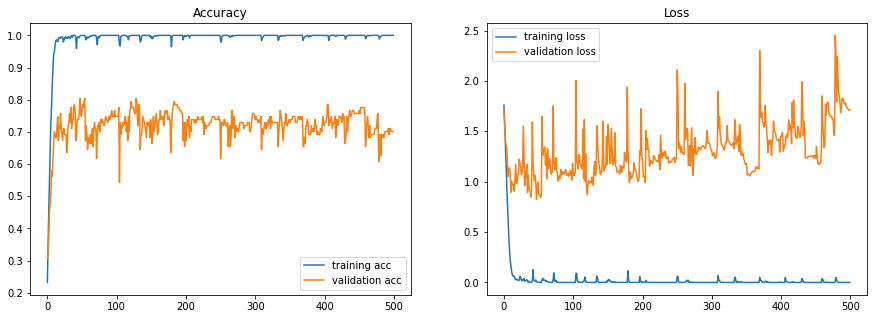

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.title('Accuracy')
plt.plot(history.history['acc'], label = 'training acc')
plt.plot(history.history['val_acc'], label = 'validation acc')
plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label = 'training loss')
plt.plot(history.history['val_loss'], label = 'validation loss')
plt.legend()
plt.title('Loss')

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

predictions = model.predict(features)
predictions = np.argmax(predictions, axis = 1)
labels = np.argmax(all_labels, axis = 1)

print(classification_report(labels, predictions, target_names = class_name_arr))
print(confusion_matrix(labels, predictions))

               precision    recall  f1-score   support

          hug       0.20      0.20      0.20       430
       diaper       0.16      0.15      0.16       284
       hungry       0.19      0.19      0.19       387
       sleepy       0.12      0.12      0.12       310
uncomfortable       0.15      0.15      0.15       334
        awake       0.17      0.17      0.17       384

     accuracy                           0.17      2129
    macro avg       0.16      0.16      0.16      2129
 weighted avg       0.17      0.17      0.17      2129

[[84 40 77 75 67 87]
 [47 44 44 40 49 60]
 [79 58 75 56 54 65]
 [68 40 59 36 51 56]
 [64 49 62 52 50 57]
 [88 50 69 53 58 66]]


In [ ]:
def print_prediction_sta(file_name):

  temp_file_info = vggish_input.wavfile_to_examples(file_name)
  # print(temp_file_info.shape)  (8,96,64)
  # print(doc_name_item)
  pad_width = Time_Len-len(temp_file_info)
  temp_file_info = np.pad(temp_file_info,((0,pad_width),(0,0),(0,0)),mode='constant')
  # print(temp_file_info.shape)  (10, 96, 64)
  # print(temp_file_info.ndim)
  # print("-----------------------------------------------------")
  prediction_feature = np.reshape(temp_file_info, (1,10, 96, 64, 1))
  
  # print(prediction_feature.shape)
  predict_x=model.predict(prediction_feature) 
  # print(predict_x)
  classes_x=np.argmax(predict_x,axis=1)
  # print(classes_x)
  return classes_x[0]
  # print(tf.io.gfile.listdir(Base_Filepath+'train'))
  # predicted_class = le.inverse_transform(classes_x) 
  # print(predicted_class)
  # print("The predicted class is:", predicted_class[0], '\n')

  # print("The predicted class is:", predicted_class[0], '\n') 
  # predicted_proba_vector = model.predict_proba(prediction_feature) 
  # predicted_proba = predicted_proba_vector[0]
  # for i in range(len(predicted_proba)): 
  #     category = le.inverse_transform(np.array([i]))
  #     print(category[0], "\t\t : ", format(predicted_proba[i], '.32f') )

###开测

In [ ]:
# filename = Base_Filepath+'train/sleepy/'+ 'sleepy_101_1.wav'
# filename = Base_Filepath+'train/awake/'+ 'awake_28_3_2.wav'
# filename = Base_Filepath+'train/uncomfortable/'+ 'uncomfortable_66_2_2.wav'
filename = Base_Filepath+'train/diaper/'+ 'diaper_23_3_2_2.wav'
# filename = Base_Filepath+'test/test_212.wav'
# filename = 'test_test.wav'
print_prediction_sta(filename)

1

#测试集相关函数


In [ ]:
def judgelabel(labelname):
  if labelname=='uncomfortable':
    return 4
  elif labelname=='hungry':
    return 2
  elif labelname=='awake':
    return 5
  elif labelname=='diaper':
    return 1
  elif labelname=='hug':
    return 0
  elif labelname=='sleepy':
    return 3

In [ ]:
import tensorflow as tf

test_file = "./../work.zip (Unzipped Files)/work/train"
class_name_arr = tf.io.gfile.listdir(test_file)
print(class_name_arr)
right_item_num = 0
wrong_item_num = 0
for index,sigle_filename in enumerate(class_name_arr):
    # print(str(index) +"handling...")
    #获取文件目录下的文件列表 并转换文件形式
    doc_name_arr = tf.io.gfile.listdir(test_file+'/'+sigle_filename)
    temp_label_index = judgelabel(sigle_filename)
    # print(temp_label_index)
    #处理每个单独的音频元素
    for doc_name_item in doc_name_arr:
      predict_label_index = print_prediction_sta(test_file+'/'+sigle_filename+'/'+doc_name_item)
      if predict_label_index==temp_label_index:
        right_item_num+=1
      else:
        wrong_item_num+=1
      # print(test_file+'/'+sigle_filename+'/'+doc_name_item)
print(right_item_num)
print(wrong_item_num)
print(right_item_num/(right_item_num+wrong_item_num))

['uncomfortable', 'awake', 'diaper', 'hug', 'sleepy', 'hungry']
254
40
0.8639455782312925
